## Mise en place d'un modele de Deep Learning (CNN + RNN (CTC)) permettant de prendre en entrée une image et d'avoir en sortie le mot qui s'y trouve

In [ ]:
### Don't forget to add image directory at the same place of this file

### Import

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import io
import re
import unicodedata
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda
import sys
import matplotlib.pyplot as plt
from PIL import Image
from asrtoolkit import cer
import statistics
from tqdm import tqdm
import time

# Functions file
import utils.functions as functions
from utils.SamplePreprocessor import preprocess



### Parametres

In [3]:
# CONSTANTES
PATH  = ''
CSV_FILE = 'word.csv'
IMG_SIZE = (128, 32)
MAX_TEXT_LEN = 32
MODEL_NAME_TO_SAVE = 'model_08112021_allData_final'

# directory name where pretrained model is saved
PRETRAINED_MODEL = 'model_08112021_allData_final'

# Variables
paths = []
array_pictures = []
array_words = []

In [4]:
coding: 'utf-8'
df = pd.read_csv(CSV_FILE, encoding='latin-1')

In [5]:
#Enregistrement de l'heure dans une variable afin de calculer le temps de traitement de notre model
start = time.time()

In [ ]:
#Pour lancer le notebook uniquement sur une partie des données
#df = df.head(20)

### Développement

##### - Openning images and saving images in array

In [6]:
chars = set()

for fileName, word in tqdm(zip(df.path, df.word)):
    
    #Adding all images' paths to the paths list
    paths.append(PATH + fileName)
    
    #Image reading
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    
    #Application of the preprocessing function on each image so that the size is the same for all the images (128,32)
    img = preprocess(img, IMG_SIZE)
    
    array_pictures.append(img)
    array_words.append(word)

#Conversion of arrays containing images and words in numpy array
array_pictures = np.array(array_pictures)
array_words = np.array(array_words)

#Composition of a list containing all the possible characters in the words contained in the images
charList = list(string.ascii_letters)+[' ']
print('Shape of array_pictures :', array_pictures.shape)
print('---  Shape of Chars list :  -',  len(charList))
print('Chars list :', charList )

array_words = np.array(list(map(lambda x: x.replace(" ", ""), array_words)))


115320it [02:29, 771.06it/s]


Shape of array_pictures : (115320, 128, 32)
---  Shape of Chars list :  - 53
Chars list : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']


In [7]:
#Mise en forme de tous les mots de la listes des mots par la fonction preprocess-sentence
array_words_transform = list(map(lambda x : functions.preprocess_sentence(x), array_words))


array_pictures = array_pictures[array_words_transform==array_words]
array_words = array_words[array_words_transform==array_words]



##### - Separate data in train data and test data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(array_pictures, array_words, test_size=0.05, random_state=123)
print(X_train.shape)
print(y_train.shape)

(91992, 128, 32)
(91992,)


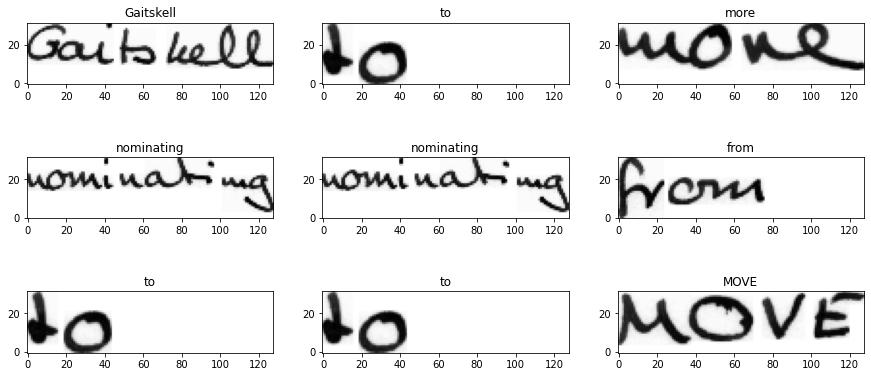

In [9]:

j = 1
plt.figure(figsize=(15,7))
for i in np.random.randint(low=0, high=10, size=[9]):
    plt.subplot(3,3,j)
    functions.plot(array_pictures[i], array_words[i])
    j+=1

#### - Implémentation du model

In [10]:

numHidden = 256

model = tf.keras.Sequential()

# Layer 1
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = (128, 32, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 4
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

In [11]:
# Remove axis 2
model.add(Lambda(lambda x :tf.squeeze(x, axis=2)))
numHidden = 256
# Bidirectionnal RNN
model.add(Bidirectional(GRU(numHidden, return_sequences=True)))

#La derniere couche Dense indique que pour chaque partie de l'image (dans notre cas découpé en 32, il y a 100 possibilité.

model.add(Dense(100))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 32, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 32, 32)       128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 32, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 16, 64)        0

In [12]:
# Composition des batch_size par epochs
dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train,-1), y_train))
dataset = dataset.shuffle(1000).batch(64)

#### - Entrainement du model

In [13]:
# Définition d'un optimisateur Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs = 5
# Entraînenement du modèle
for i in tqdm(range(epochs)): 
    # Pour chaque epoch
    print('---- Epoch', i, '----')
    for X_b, y_b in dataset:
        try :
            y_ba = functions.encode_labels(y_b, charList)
            functions.train_op(model, X_b, y_ba, optimizer)
        except :
            print("Unexpected error:", sys.exc_info()[0])
            time.sleep(0.5)

  0%|          | 0/5 [00:00<?, ?it/s]

---- Epoch 0 ----


 20%|██        | 1/5 [26:38<1:46:33, 1598.32s/it]

---- Epoch 1 ----


 40%|████      | 2/5 [53:39<1:20:15, 1605.08s/it]

---- Epoch 2 ----


 60%|██████    | 3/5 [1:20:24<53:30, 1605.29s/it]

---- Epoch 3 ----


 80%|████████  | 4/5 [1:47:23<26:49, 1609.26s/it]

---- Epoch 4 ----


100%|██████████| 5/5 [2:14:44<00:00, 1617.00s/it]


In [14]:
#Affichage de quelques mots décodés pour avoir une idée du résultat obtenu par le model
l = functions.greedy_decoder(model(np.expand_dims(X_test[:10], -1)), charList)
list(zip(l, y_test[:10]))

[('story', 'story'),
 ('pesple', 'people'),
 ('hww', 'how'),
 ('thorough', 'thorough'),
 ('financial', 'financial'),
 ('we', 'we'),
 ('usualy', 'usually'),
 ('the', 'the'),
 ('make', 'make'),
 ('seae', 'sex')]

In [15]:
#Enregistrement du model
model.save(MODEL_NAME_TO_SAVE)


INFO:tensorflow:Assets written to: model_08112021_allData_final\assets


INFO:tensorflow:Assets written to: model_08112021_allData_final\assets


In [16]:
end = time.time()
duration = end - start

print('--------------------------------------------------')
print ( '--- FIN DE L\'ENTRAINEMENT DU MODELE')
print('--- Nom du model : ', MODEL_NAME_TO_SAVE)
print('--- Model entrainer sur : ', len(y_train), '  images')
print('--- Durée d\'entrainement : ', np.round((duration/60)/60, 2) , 'heures')

--------------------------------------------------
--- FIN DE L'ENTRAINEMENT DU MODELE
--- Nom du model :  model_08112021_allData_final
--- Model entrainer sur :  91992   images
--- Durée d'entrainement :  2.31 heures


In [17]:
#Chargement du model complet

#model = keras.models.load_model(PRETRAINED_MODEL)